In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
plt.rcParams.update({'font.size': 28, 'text.usetex': True})

torch.set_default_device('cuda')
torch.set_default_dtype(torch.float64)

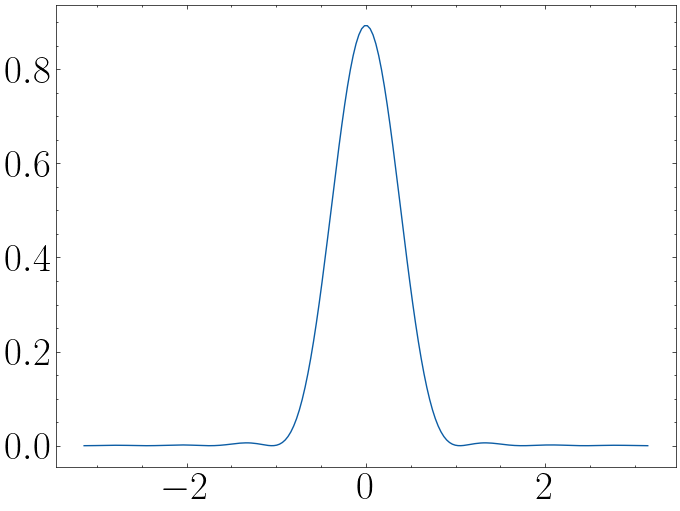

In [2]:
def construct_sine_polynomial(N, theta):
    """Construct sine polynomial as in qsp_dec.ipynb"""
    p_theta = torch.zeros_like(theta, dtype=torch.complex128)
    normalization = np.sqrt(2.0 / (N * (N + 1)))
    
    for k in range(N):
        sine_coeff = np.sin((k + 1) * np.pi / (N + 1))
        phase = torch.exp(1j * k * theta)
        p_theta += normalization * sine_coeff * phase
    
    return torch.abs(p_theta)**2

plt.figure(figsize=(8, 6))
plt.plot(np.linspace(-np.pi, np.pi, 200), construct_sine_polynomial(8, torch.linspace(-np.pi, np.pi, 200)).cpu().numpy())
plt.show()

In [3]:
def compute_qae_probabilities(a, N):
    """Compute P(k|a) for quantum amplitude estimation using equation (eq:amp_kth)"""
    theta_a = torch.arcsin(torch.sqrt(a))*2  # a_theta = arcsin(sqrt(a))
    n_k = N//2 + 1  # k = 0, 1, ..., N (full range to cover a in [0, 1])
    
    probs = torch.zeros(len(a), n_k, dtype=torch.float64)
    
    for k in range(n_k):
        theta_k = k * np.pi * 2 / N
        if k == 0 or k == N//2:
            # k = 0 or N (boundaries)
            probs[:, k] = construct_sine_polynomial(N, theta_a - theta_k)
        else:
            # k = 1, ..., N - 1
            probs[:, k] = (construct_sine_polynomial(N, theta_a - theta_k) + 
                          construct_sine_polynomial(N, theta_a + theta_k))
    return probs

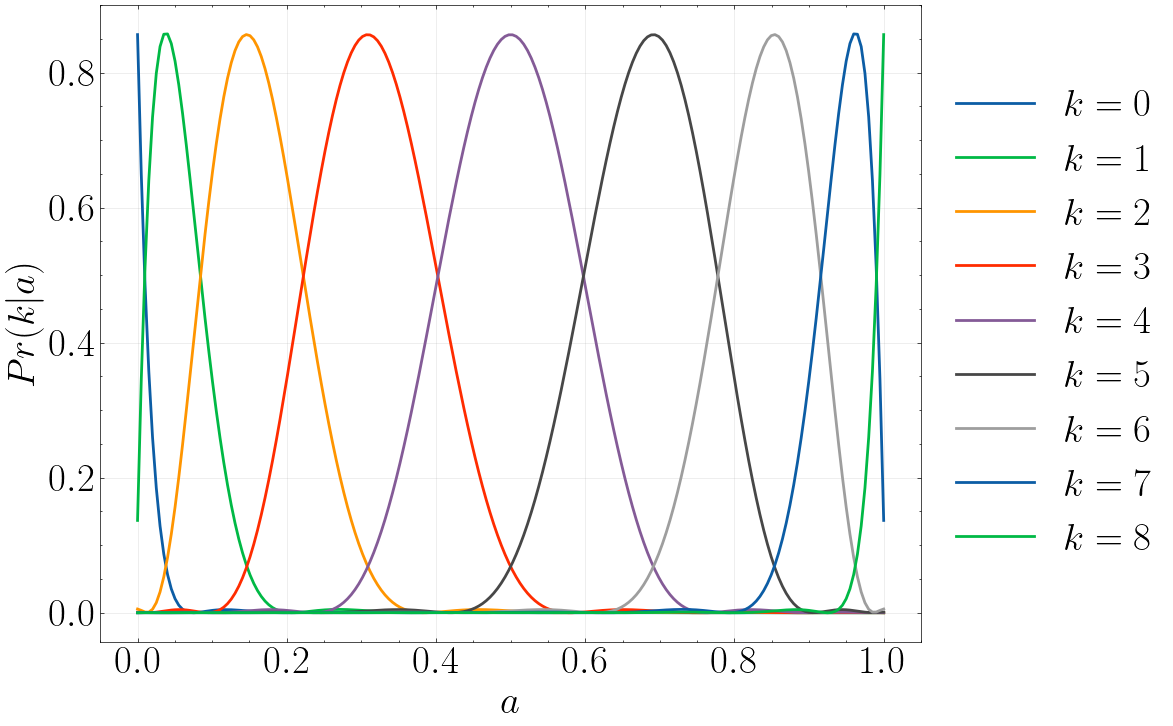

Sum of probabilities - min: 1.000000, max: 1.000000


In [4]:
# Diagnostic: Plot probability curves for N=8
N_test = 16
a_test = torch.linspace(0.0, 1.0, 200, dtype=torch.float64)
probs_test = compute_qae_probabilities(a_test, N_test)

plt.figure(figsize=(10, 8))
n_k = N_test // 2 + 1
for k in range(n_k):
    plt.plot(a_test.cpu().numpy(), probs_test[:, k].cpu().numpy(), 
             label=f'$k={k}$', linewidth=2)

# Also plot the sum to verify it's 1
prob_sum = probs_test.sum(dim=1)
# plt.plot(a_test.cpu().numpy(), prob_sum.cpu().numpy(), 'k--', linewidth=3, label='Sum', alpha=0.7)

plt.xlabel(r'$a$')
plt.ylabel(r'$Pr(k|a)$')
# plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'qae_probs.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Sum of probabilities - min: {prob_sum.min().item():.6f}, max: {prob_sum.max().item():.6f}")

Processing N=8...
Processing N=16...
Processing N=32...
Processing N=64...
Processing N=128...
Processing N=256...
Processing N=512...
Processing N=1024...
Done!


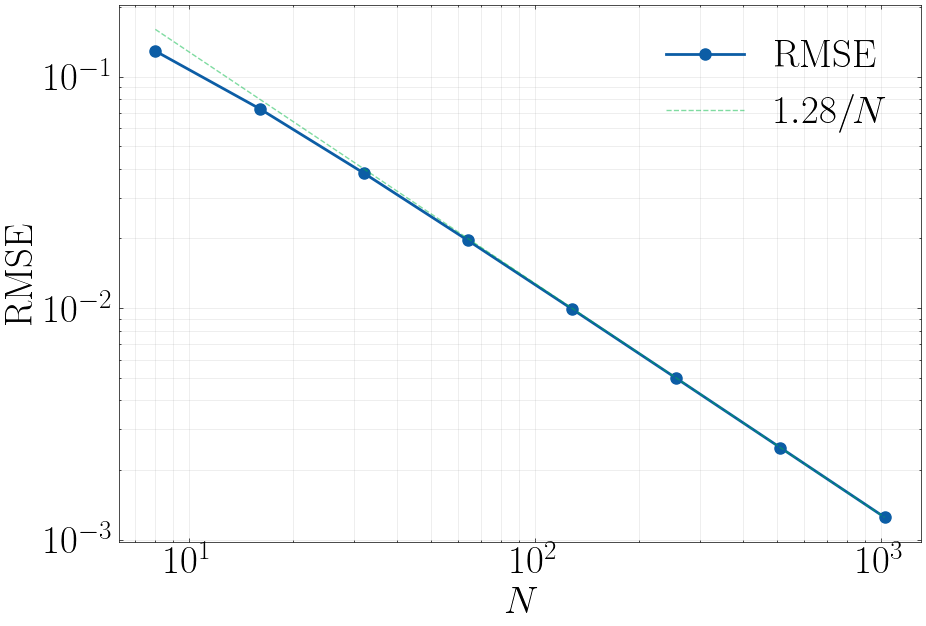

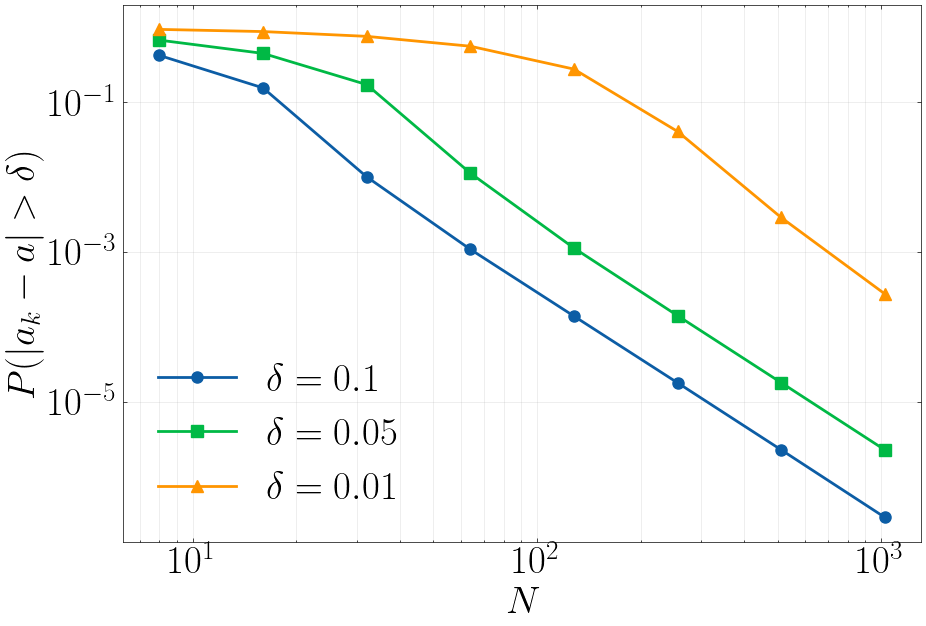


RMSE values:
  N=   8: RMSE = 0.129003
  N=  16: RMSE = 0.072752
  N=  32: RMSE = 0.038344
  N=  64: RMSE = 0.019625
  N= 128: RMSE = 0.009919
  N= 256: RMSE = 0.004985
  N= 512: RMSE = 0.002499
  N=1024: RMSE = 0.001251

Error probabilities:
   N       δ=0.1      δ=0.05      δ=0.01
   8    0.420196    0.672059    0.935357
  16    0.154828    0.447220    0.874963
  32    0.010066    0.171478    0.755349
  64    0.001086    0.011293    0.557786
 128    0.000139    0.001129    0.275980
 256    0.000018    0.000141    0.040668
 512    0.000002    0.000018    0.002888
1024    0.000000    0.000002    0.000276


In [5]:
# Compute RMSE and error probabilities for different N values
N_values = [2**i for i in range(3, 11)]  # N = 8, 16, 32, 64, 128, 256, 512, 1024
n_samples = 4096  # Number of samples for numerical integration
a_samples = torch.linspace(0.0, 1.0, n_samples, dtype=torch.float64)
da = a_samples[1] - a_samples[0]  # differential element

rmse_values = []
prob_error_01 = []  # delta = 0.1
prob_error_005 = []  # delta = 0.05
prob_error_001 = []  # delta = 0.01

for N in N_values:
    print(f"Processing N={N}...")
    n_k = N // 2 + 1
    
    # Compute probabilities for all a values
    probs = compute_qae_probabilities(a_samples, N)
    
    # For each k, compute Bayesian estimate a_k and all errors in one loop
    squared_errors_sum = 0.0
    prob_error_01_sum = 0.0
    prob_error_005_sum = 0.0
    prob_error_001_sum = 0.0
    
    for k in range(n_k):
        # Bayesian estimate: a_k = int(a * P(k|a) da) / int(P(k|a) da)
        numerator = torch.sum(a_samples * probs[:, k]) * da
        denominator = torch.sum(probs[:, k]) * da
        a_k = numerator / denominator
        
        # Compute error |a_k - a_true| for all a_true
        errors_k = torch.abs(a_k - a_samples)
        
        # Accumulate weighted squared errors for RMSE
        squared_errors_sum += torch.sum((errors_k ** 2) * probs[:, k]) * da
        
        # Accumulate error probabilities for different delta values
        mask_01 = errors_k > 0.1
        prob_error_01_sum += torch.sum(probs[:, k] * mask_01.float()) * da
        
        mask_005 = errors_k > 0.05
        prob_error_005_sum += torch.sum(probs[:, k] * mask_005.float()) * da
        
        mask_001 = errors_k > 0.01
        prob_error_001_sum += torch.sum(probs[:, k] * mask_001.float()) * da
    
    # Store results
    rmse = torch.sqrt(squared_errors_sum)
    rmse_values.append(rmse.item())
    prob_error_01.append(prob_error_01_sum.item())
    prob_error_005.append(prob_error_005_sum.item())
    prob_error_001.append(prob_error_001_sum.item())

print("Done!")

# Plot RMSE vs N
plt.figure(figsize=(10, 7))
N_array = np.array(N_values)
plt.loglog(N_array, rmse_values, 'o-', linewidth=2, markersize=8, label='RMSE')
# Add reference line with specific scaling coefficient
scaling_coeff = 1.28
reference_line = scaling_coeff / N_array
plt.loglog(N_array, reference_line, '--', alpha=0.5, label=f'${scaling_coeff:.2f}/N$')
plt.xlabel(r'$N$')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.savefig('qae_rmse_vs_n.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot error probabilities vs N
plt.figure(figsize=(10, 7))
plt.loglog(N_array, prob_error_01, 'o-', linewidth=2, markersize=8, label=r'$\delta = 0.1$')
plt.loglog(N_array, prob_error_005, 's-', linewidth=2, markersize=8, label=r'$\delta = 0.05$')
plt.loglog(N_array, prob_error_001, '^-', linewidth=2, markersize=8, label=r'$\delta = 0.01$')
plt.xlabel(r'$N$')
plt.ylabel(r'$P(|a_k - a| > \delta)$')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.savefig('qae_prob_error_vs_n.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\nRMSE values:")
for N, rmse in zip(N_values, rmse_values):
    print(f"  N={N:4d}: RMSE = {rmse:.6f}")

print("\nError probabilities:")
print(f"{'N':>4s}  {'δ=0.1':>10s}  {'δ=0.05':>10s}  {'δ=0.01':>10s}")
for i, N in enumerate(N_values):
    print(f"{N:4d}  {prob_error_01[i]:10.6f}  {prob_error_005[i]:10.6f}  {prob_error_001[i]:10.6f}")